# End-To-End Model Driven Tutorial

In [1]:
import sys
import os

if os.path.exists('../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../')  # This line is need to import pynncml
else:
    print("Install PyNNCML From pip")
    !pip install pynncml

import numpy as np
import pynncml as pnc
import matplotlib as mpl
from matplotlib import pyplot as plt
from pynncml import plot_wet_dry_detection_mark


Install PyNNCML From pip


# Load OpemMRG Dataset

In [2]:
xy_min = [1.29e6, 0.565e6]  # Link Region
xy_max = [1.34e6, 0.5875e6]
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
link_set, ps = pnc.datasets.load_open_mrg(xy_min=xy_min, xy_max=xy_max, time_slice=time_slice, change2min_max=True)

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [00:27<00:00, 26.69it/s]


# Plot link data

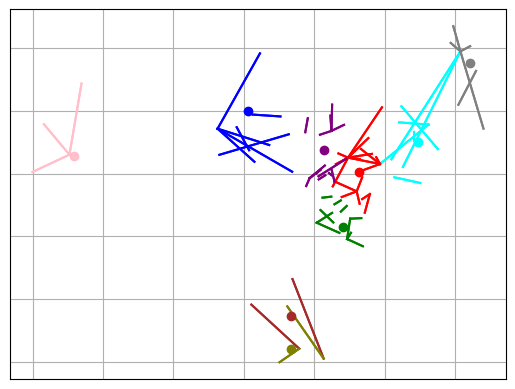

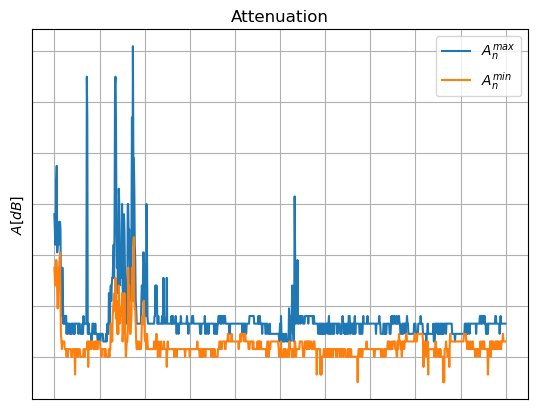

In [15]:
link_set.plot_links(scale=True, scale_factor=64)
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.title("")
plt.show()

link_set.get_link(0).plot()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()


# Wet-Dry classification using statistics test.

 ![image](./examples/tutorials/wet_dry_location.png) <br>
 
This section performance wet dry classification using statistics test, this method introduced by [1]. The first step is calculating the standard deviation over a window of samples using the following equation: <br>
$$\sigma_n=\Bigg[\frac{1}{|W_n|}\sum_{k \in W_n}\Big(A_k-E_{W_n}[A]\Big)^2\Bigg]^{\frac{1}{2}} $$ <br>
where $W_n$ is a moving standard deviation window in range $[n,n+N_w]$ , $A_k$ is the instance attenuation measurement of sample $k$ and $A$ is the vector of all samples and
$N_w=|W_n|$ is an hyper-parameter that set the window size.  
$$E_{W_n}[A]=\frac{1}{|W_n|}\sum_{k \in W_n}A_k $$  
Once we obtained the standard deviation vector $\sigma_n$, the following threshold function is apply
\begin{equation}
\hat{y}^{wd}_n=\begin{cases}
1 \quad \sigma_n>\sigma_0 \\
0 \quad\text{o.w} 
\end{cases}
\end{equation} <br>
where $\hat{y}^{wd}_n=1$ is wet even and $\hat{y}^{wd}_n=0$ is dry event and $\sigma_0$ is an hyper-parameter. 

## Run wet dry classification

In [6]:
swd = pnc.scm.wet_dry.statistics_wet_dry(0.6, 4, is_min_max=True)  # init classification model
wd_classification, std_vector = swd(link_set.get_link(0).attenuation())  # run classification method
ref = link_set.get_link(0).gauge_ref.data_array

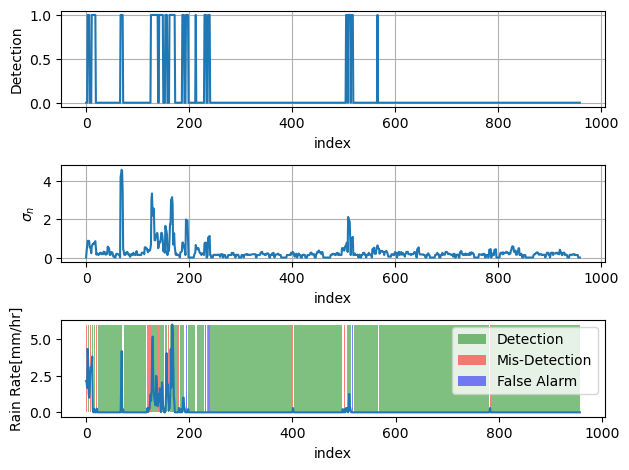

In [7]:
_, ax = plt.subplots(3, 1)
ax[0].plot(wd_classification.numpy()[0, :])
ax[0].set_xlabel('index')
ax[0].set_ylabel('Detection')
ax[0].grid()
ax[1].plot(std_vector.numpy()[0, :])
ax[1].set_xlabel('index')

ax[1].set_ylabel(r'$\sigma_n$')
ax[1].grid()
ax[2].plot(ref)
plot_wet_dry_detection_mark(ax[2], np.arange(len(ref)), wd_classification.numpy()[0, :-2], ref)
ax[2].legend()
ax[2].set_xlabel('index')
ax[2].set_ylabel(r'Rain Rate[mm/hr]')
plt.tight_layout()
plt.show()



## Run constant baseline

 ![image](.\baseline_location.png )<br>



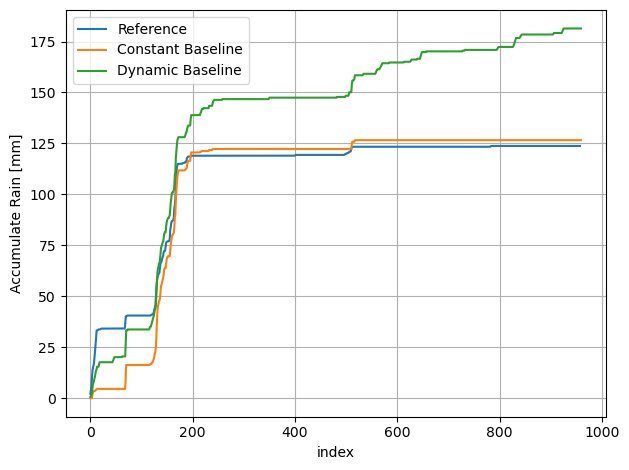

In [8]:
tsc = pnc.scm.rain_estimation.two_step_constant_baseline(pnc.scm.power_law.PowerLawType.MAX, 0.1, 8, 0.1, wa_factor=2.0)
os_baseline = pnc.scm.rain_estimation.one_step_dynamic_baseline(pnc.scm.power_law.PowerLawType.MAX, 0.3, 4, 1)


plt.plot(np.cumsum(ref), label="Reference")
rain, wd = tsc(link_set.get_link(0).attenuation().T.unsqueeze(dim=0),
               link_set.get_link(0).meta_data)  # run constant baseline
plt.plot(np.cumsum(rain), label="Constant Baseline")
rain=os_baseline(link_set.get_link(0).attenuation().T.unsqueeze(dim=0),
               link_set.get_link(0).meta_data)
plt.plot(np.cumsum(rain), label="Dynamic Baseline")
plt.xlabel("index")
plt.ylabel("Accumulate Rain [mm]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Rain Maps


In [9]:
imc = pnc.mcm.InferMultipleCMLs(os_baseline)
res = imc(link_set)

In [10]:
idw = pnc.mcm.generate_link_set_idw(link_set, roi=3)
rain_map = idw(res).numpy()

In [11]:
gmz = pnc.mcm.generate_link_set_gmz(link_set, roi=3)
rain_map_gmz, losses = gmz(res)
rain_map_gmz = rain_map_gmz.numpy()

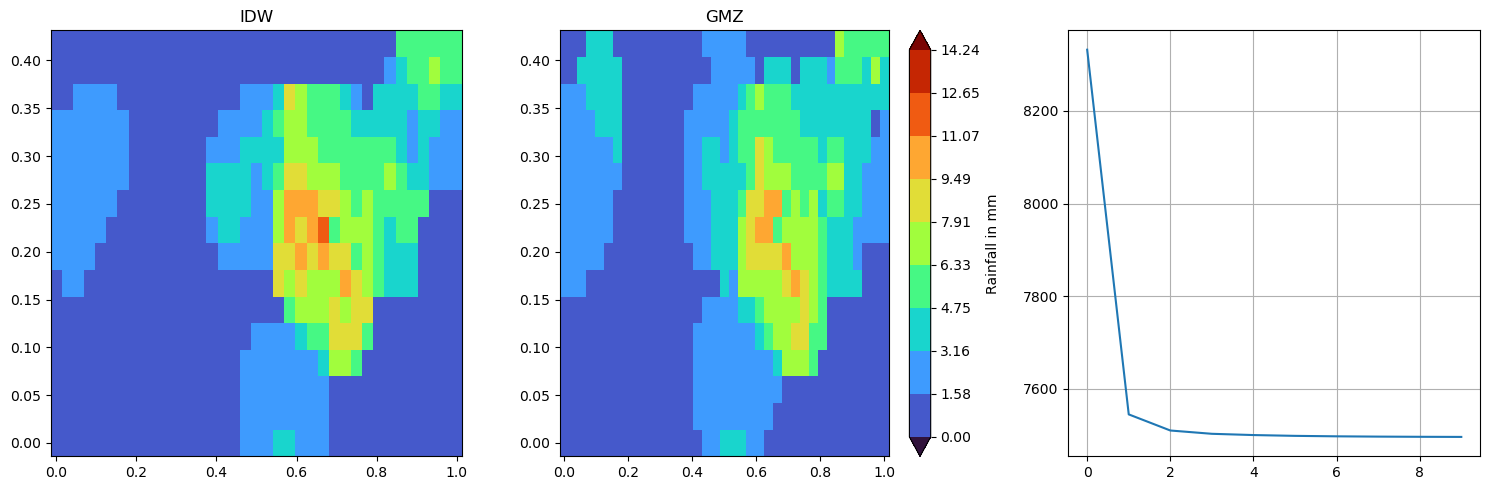

In [13]:
index = np.argmax(np.std(rain_map, axis=(1, 2)))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak_rain = np.max([np.max(rain_map), np.max(rain_map_gmz)])
bounds = np.arange(0,peak_rain , peak_rain/10)
# bounds[0] = 1

norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

pc_zero = ax[0].pcolormesh(
    idw.x_grid_vector,
    idw.y_grid_vector,
    rain_map[index, :, :].T,
    shading='nearest',
    cmap='turbo',
    norm=norm,
)
ax[0].set_title('IDW')
pc_one = ax[1].pcolormesh(
    idw.x_grid_vector,
    idw.y_grid_vector,
    rain_map_gmz[index, :, :].T,
    shading='nearest',
    cmap='turbo',
    norm=norm,
)
ax[1].set_title('GMZ')

ax[2].plot(losses[:,index])
ax[2].grid()
fig.colorbar(pc_one, label='Rainfall in mm')
plt.tight_layout()
plt.show()


# References
[1] Marc Schleiss and Alexis Berne. Identification of dry and rainy periods using telecommuni-
cation microwave links. IEEE Geoscience and Remote Sensing Letters, 7(3):611–615, 2010

